In [27]:
import numpy as np 
import pandas as pd 

In [28]:
filepath = '/Users/simonwsy/Desktop/code/BTC_price_predict/data-BTC-USDT-from-2022-09-01-to-2023-10-01.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Timestamp')
data['Date'] = data['Timestamp']
data.head()

,Timestamp,Open,High,Low,Close,Date
0,2022-09-01 16:00:00,19783.7,20437.1,19568.8,20357.2,2022-09-01 16:00:00
1,2022-09-02 16:00:00,20357.7,20380.2,19731.4,19770.9,2022-09-02 16:00:00
2,2022-09-03 16:00:00,19770.7,19937.2,19587.1,19791.3,2022-09-03 16:00:00
3,2022-09-04 16:00:00,19791.3,20055.8,19638.4,19855.0,2022-09-04 16:00:00
4,2022-09-05 16:00:00,19855.1,20180.0,19668.1,19818.4,2022-09-05 16:00:00


In [29]:
data.shape

(299, 6)

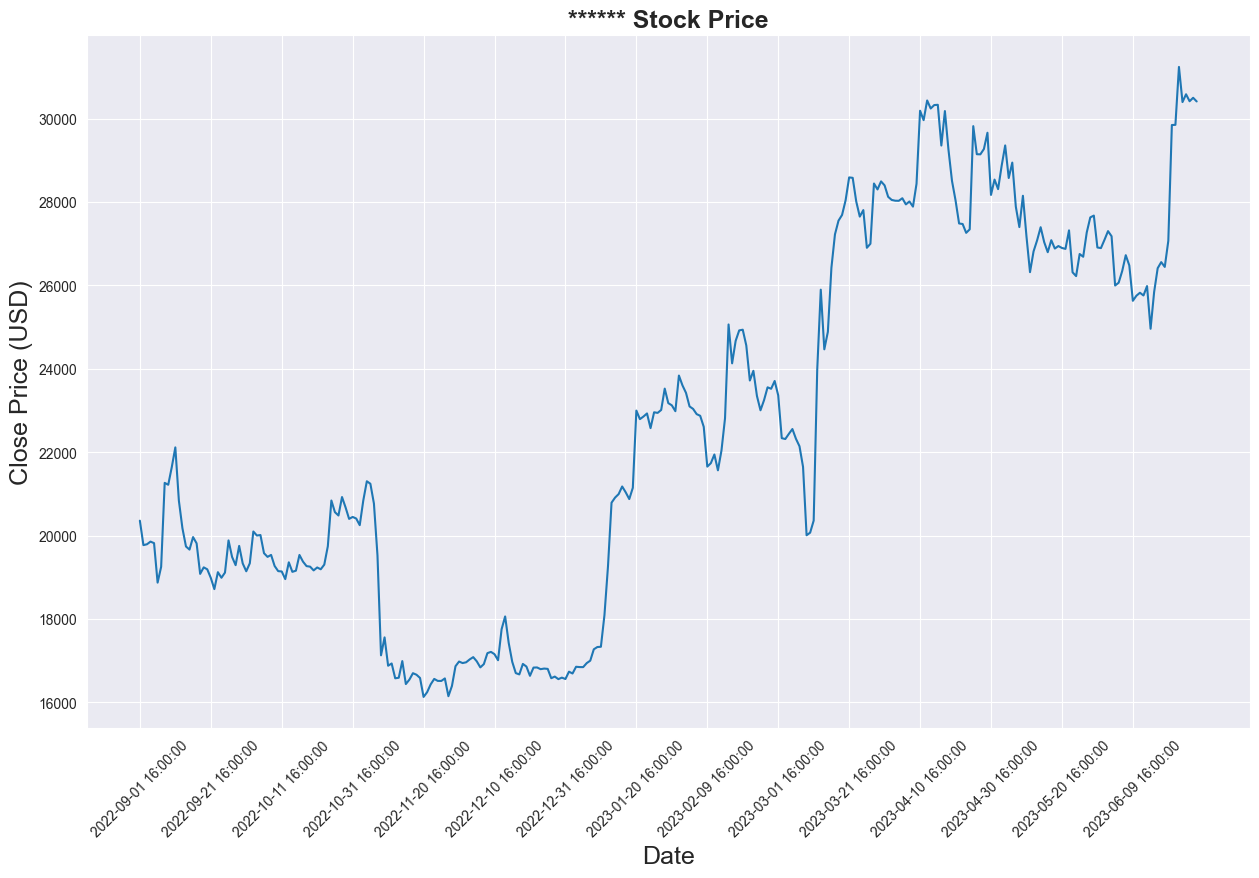

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],20), data['Date'].loc[::20], rotation=45)
plt.title("****** Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

# 1. 特征工程

In [31]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   299 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/l3/3nn8r4195jx8b6rzwks1y1pr0000gn/T/ipykernel_2790/68737012.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
price['Close'].shape

(299,)

# 2. 数据集制作

In [34]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [35]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (223, 19, 1)
y_train.shape =  (223, 1)
x_test.shape =  (56, 19, 1)
y_test.shape =  (56, 1)


注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)

# 3. 模型构建 —— LSTM

In [36]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [37]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [39]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. 模型训练

In [40]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4050862193107605
Epoch  1 MSE:  0.327059268951416
Epoch  2 MSE:  0.2838348150253296
Epoch  3 MSE:  0.2789047360420227


Epoch  4 MSE:  0.2238505631685257
Epoch  5 MSE:  0.17059728503227234
Epoch  6 MSE:  0.11794226616621017
Epoch  7 MSE:  0.0862615555524826
Epoch  8 MSE:  0.07902920246124268
Epoch  9 MSE:  0.08460449427366257
Epoch  10 MSE:  0.06438247114419937
Epoch  11 MSE:  0.04825129359960556
Epoch  12 MSE:  0.035554271191358566
Epoch  13 MSE:  0.03268206864595413
Epoch  14 MSE:  0.03418513387441635
Epoch  15 MSE:  0.03567248955368996
Epoch  16 MSE:  0.036403510719537735
Epoch  17 MSE:  0.03545278683304787
Epoch  18 MSE:  0.0324292816221714
Epoch  19 MSE:  0.028570519760251045
Epoch  20 MSE:  0.0250092763453722
Epoch  21 MSE:  0.02167586237192154
Epoch  22 MSE:  0.01877010427415371
Epoch  23 MSE:  0.01724623329937458
Epoch  24 MSE:  0.016592442989349365
Epoch  25 MSE:  0.016125669702887535
Epoch  26 MSE:  0.016413478180766106
Epoch  27 MSE:  0.016266368329524994
Epoch  28 MSE:  0.016206204891204834
Epoch  29 MSE:  0.015981106087565422
Epoch  30 MSE:  0.015483774244785309
Epoch  31 MSE:  0.0150804594

# 5. 模型结果可视化

In [41]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

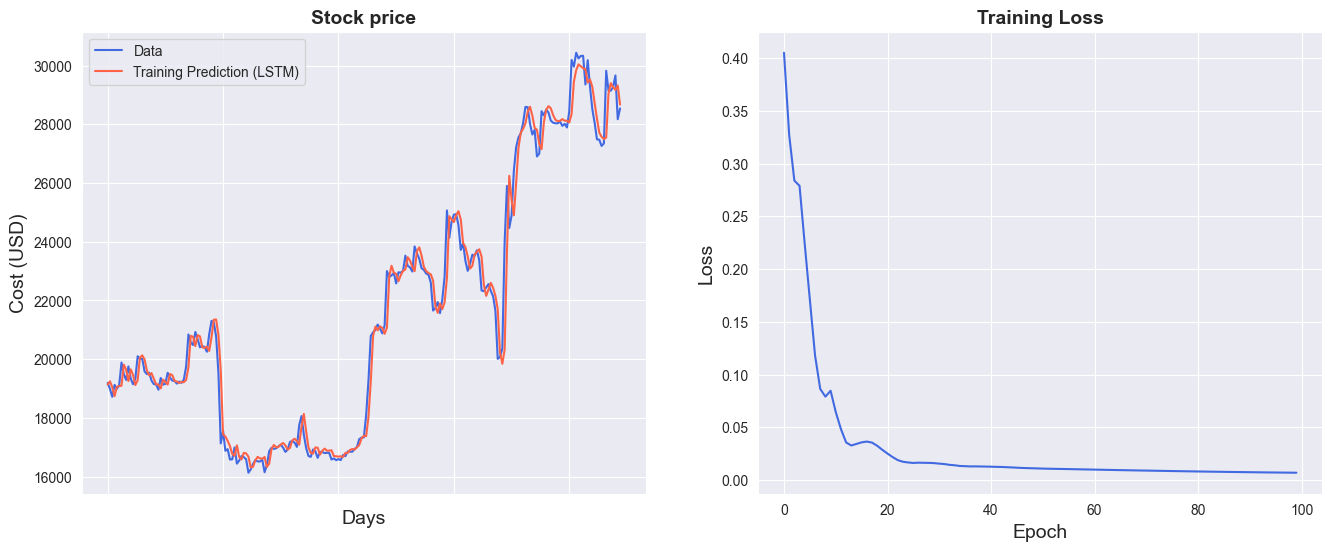

In [42]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# 6. 模型验证

In [43]:
x_test[-1]

tensor([[0.4023],
        [0.3698],
        [0.2575],
        [0.2736],
        [0.2831],
        [0.2744],
        [0.3043],
        [0.1688],
        [0.2854],
        [0.3610],
        [0.3803],
        [0.3651],
        [0.4479],
        [0.8156],
        [0.8161],
        [1.0000],
        [0.8885],
        [0.9132],
        [0.8911]])

In [44]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 626.52 RMSE
Test Score: 701.94 RMSE


In [45]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [46]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()